### Denoising fMRI Scans with Diffusion Models:

## Training with Anatomy as Condition and Masked Loss

This Code is based on the implementation of the Super-Resolution Network SR3: https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement.git

Changes were made throughout the full code to convert the super-resolution architecture to a denoising-architecture with an additional condition (Structural MRI / anatomy) and masked loss.
______

Imports

In [ ]:
import torch
import logging
import os
import numpy as np
import copy
from torch.utils.data import Dataset
from collections import OrderedDict
import functools
from torch.nn import init

# U-Net
import math
from inspect import isfunction

# Diffusion
from torch import nn
from functools import partial
from tqdm import tqdm

# learning rate scheduler
import torch.optim.lr_scheduler as lr_scheduler

# mixed precision training for memory
from torch.cuda.amp import GradScaler

# read masks
import nibabel as nib
import matplotlib.pyplot as plt

Config

In [3]:
opt = {
    "name": "denoising",
    "phase": "train",
    "gpu_ids": [0, 1], 
    "debug": False,  
    "enable_wandb": False,  
    "log_wandb_ckpt": False,  
    "log_eval": False,  
    "path": {
        "log": "/kaggle/working/logs",
        "tb_logger": "/kaggle/working/tb_logger",
        "results": "/kaggle/working/results",
        "checkpoint": "/kaggle/working/checkpoint",
        "resume_state": None
    },
    "datasets": {
        "train": {
            "noisy_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/noisy_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/noisy_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/noisy_func_train_3.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/gt_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/gt_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/gt_func_train_3.npy'],
            "mask_data_paths": ['/kaggle/input/brain-mask-01/brain_mask_01.nii',
                '/kaggle/input/brain-mask-dd/brain_mask_dd.nii',
                '/kaggle/input/brain-mask-gg/brain_mask_gg.nii'],
            "anat_data_paths": ['/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-01_smri_coregistered.nii',
                '/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-dd_smri_coregistered.nii',
                '/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-gg_smri_coregistered.nii'],
            "batch_size": 2,
            "num_workers": 4,
            "use_shuffle": True
        },
        "test": {
            "noisy_data_paths": ['/kaggle/input/fmri-test-norm-v3/data/noisy_func_test.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-test-norm-v3/data/gt_func_test.npy'],
            "mask_data_paths": ['/kaggle/input/brain-mask-uu/brain_mask_uu.nii'],
            "anat_data_paths": ['/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-uu_smri_coregistered.nii'],
            "batch_size": 2,
            "num_workers": 4,
        }
    },
    "model": {
        "which_model_G": "sr3",
        "finetune_norm": False,
        "unet": {
            "in_channel": 3,
            "out_channel": 1,
            "inner_channel": 32,
            "norm_groups": 16,
            "channel_multiplier": [1, 2, 4, 8],
            "attn_res": [8],
            "res_blocks": 1,
            "dropout": 0.1
        },
        "beta_schedule": {
            "train": {
                "schedule": "cosine",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            },
            "test": {
                "schedule": "cosine",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
        },
        "diffusion": {
            "image_size": 64,
            "channels": 1,
            "conditional": True
        }
    },
    "train": {
        "n_iter": 27000,
        "val_freq": 1e4,
        "save_checkpoint_freq": 1000,
        "print_freq": 100,
        "accumulation_steps": 2,
        "optimizer": {
            "type": "adam",
            "lr": 5e-6
        },
        "ema_scheduler": {
            "step_start_ema": 9000,
            "update_ema_every": 10,
            "ema_decay": 0.999
        }
    },
    "wandb": {
        "project": "distributed_high_sr_ffhq"
    },
    "config_file": "config/sr_sr3_16_128.json"  # from CLI
}

In [ ]:
os.makedirs(opt['path']['log'], exist_ok=True)
os.makedirs(opt['path']['tb_logger'], exist_ok=True)
os.makedirs(opt['path']['results'], exist_ok=True)
os.makedirs(opt['path']['checkpoint'], exist_ok=True)

Logger

In [ ]:
# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def dict2str(opt, indent_l=1):
    '''dict to string for logger'''
    msg = ''
    for k, v in opt.items():
        if isinstance(v, dict):
            msg += ' ' * (indent_l * 2) + k + ':[\n'
            msg += dict2str(v, indent_l + 1)
            msg += ' ' * (indent_l * 2) + ']\n'
        else:
            msg += ' ' * (indent_l * 2) + k + ': ' + str(v) + '\n'
    return msg

def setup_logger(logger_name, root, phase, level=logging.INFO, screen=False):
    '''set up logger'''
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(
        '%(asctime)s.%(msecs)03d - %(levelname)s: %(message)s', datefmt='%y-%m-%d %H:%M:%S')
    log_file = os.path.join(root, '{}.log'.format(phase))
    fh = logging.FileHandler(log_file, mode='w')
    fh.setFormatter(formatter)
    l.setLevel(level)
    l.addHandler(fh)
    if screen:
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        l.addHandler(sh)


setup_logger(None, opt['path']['log'],
                    'train', level=logging.INFO, screen=True)
setup_logger('val', opt['path']['log'], 'val', level=logging.INFO)
logger = logging.getLogger('base')

Dataset creation

In [ ]:
class PairwiseDataset(Dataset):
    def __init__(self, noisy_images_paths: list, gt_images_paths: list, mask_images_paths: list, anat_images_paths: list):
        """Initialize fMRI dataset for denoising with memory-efficient loading."""
        self.noisy_paths = noisy_images_paths
        self.gt_paths = gt_images_paths
        self.mask_paths = mask_images_paths
        self.anat_paths = anat_images_paths

        # Pre-load the anatomy and mask volumes into a list in memory
        self.anat_volumes = [nib.load(path).get_fdata() for path in anat_images_paths]
        self.mask_volumes = [nib.load(path).get_fdata() for path in mask_images_paths]

    
        self.file_slice_mapping = []
        for i, path in enumerate(noisy_images_paths):
            data_shape = np.load(path, mmap_mode='r').shape
            for t_idx in range(data_shape[3]):
                self.file_slice_mapping.append((i, t_idx))
        self.data_len = len(self.file_slice_mapping)

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        file_idx, t_idx = self.file_slice_mapping[index]
        
        noisy_file_path = self.noisy_paths[file_idx]
        gt_file_path = self.gt_paths[file_idx]
        
        noisy_volume = np.load(noisy_file_path, mmap_mode='r')
        gt_volume = np.load(gt_file_path, mmap_mode='r')
        mask_volume = self.mask_volumes[file_idx]
        anat_volume = self.anat_volumes[file_idx]
        
        noisy_slice = noisy_volume[:, :, :, t_idx].copy()
        gt_slice = gt_volume[:, :, :, t_idx].copy()
        mask_slice = mask_volume.copy()
        anat_slice = anat_volume.copy()

        def to_tensor(data):
            return torch.tensor(data).float().unsqueeze(0).permute(-1, 0, 1, 2)

        return {
            'GT': to_tensor(gt_slice),
            'Noisy': to_tensor(noisy_slice),
            'Mask': to_tensor(mask_slice),
            'Anat': to_tensor(anat_slice),
            'Index': index
        }

In [ ]:
def collate_merge_batches(batch):
    """Correctly concatenates tensors from a list of dictionaries."""
    return {
        'Noisy': torch.cat([item['Noisy'] for item in batch], dim=0),
        'GT': torch.cat([item['GT'] for item in batch], dim=0),
        'Mask': torch.cat([item['Mask'] for item in batch], dim=0),
        'Anat': torch.cat([item['Anat'] for item in batch], dim=0),
        'Index': [item['Index'] for item in batch]
    }

def create_dataloader(dataset, dataset_opt, phase):
    """Creates dataloader for training or testing."""
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=dataset_opt['batch_size'],
        shuffle=dataset_opt.get('use_shuffle', False),
        num_workers=dataset_opt.get('num_workers', 1),
        pin_memory=True,
        collate_fn=collate_merge_batches
    )

In [8]:
# Create training dataset and dataloader
train_set = PairwiseDataset(
    opt['datasets']['train']['noisy_data_paths'], 
    opt['datasets']['train']['gt_data_paths'],
    opt['datasets']['train']['mask_data_paths'],
    opt['datasets']['train']['anat_data_paths']
)
train_loader = create_dataloader(train_set, opt['datasets']['train'], 'train')
logger.info(f"Training dataset with {len(train_set)} instances created.")

test_set = PairwiseDataset(
    opt['datasets']['test']['noisy_data_paths'], 
    opt['datasets']['test']['gt_data_paths'],
    opt['datasets']['test']['mask_data_paths'],
    opt['datasets']['test']['anat_data_paths']
)
test_loader = create_dataloader(test_set, opt['datasets']['test'], 'test')
logger.info(f"Test dataset with {len(test_set)} instances created.")

25-06-22 02:34:06.968 - INFO: Training dataset with 900 instances created.


25-06-22 02:34:07.052 - INFO: Test dataset with 300 instances created.


In [10]:
noisy_slice = train_set[400]["Noisy"]
gt_slice = train_set[400]["GT"]

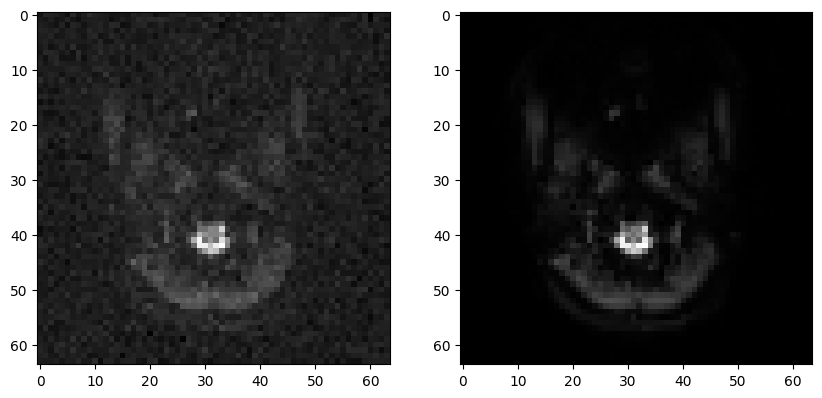

In [ ]:
# visualization of example slice
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth image
axes[0].imshow(noisy_slice[0,0,:,:], cmap='gray')
axes[1].imshow(gt_slice[0,0,:,:], cmap='gray')

### Model loading

Generic Functions

In [13]:
# generic functions
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

U-Net

In [ ]:
# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
    
        
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

Diffusion

In [ ]:
### Diffusion ###
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


# gaussian diffusion trainer class
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True,
        schedule_opt=None
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        if schedule_opt is not None:
            pass


    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, schedule_opt, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        
        sqrt_alphas_cumprod_prev_np = np.sqrt(np.append(1., alphas_cumprod))
        self.register_buffer('sqrt_alphas_cumprod_prev', to_torch(sqrt_alphas_cumprod_prev_np))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor(
            [self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(torch.cat([condition_x, x], dim=1), noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, continous=False):
        return self.p_sample_loop(x_in, continous)

    
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1) * x_start +
                self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1) * noise)

# In the GaussianDiffusion class
    def p_losses(self, x_in, noise=None):
        x_start, mask = x_in['GT'], x_in['Mask']
        b, c, h, w = x_start.shape
        t = torch.randint(0, self.num_timesteps, (b,), device=x_start.device).long()
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        
        if self.conditional:
            anat = x_in['Anat']
            # Ensure anatomy tensor is repeated to match the batch size
            if anat.shape[0] != b:
                anat = anat.repeat(b // anat.shape[0], 1, 1, 1)
                
            model_input = torch.cat([x_in['Noisy'], anat, x_noisy], dim=1)
            x_recon = self.denoise_fn(model_input, t)
        else:
            x_recon = self.denoise_fn(x_noisy, t)
        
        if mask.shape[0] != b:
            mask = mask.repeat(b // mask.shape[0], 1, 1, 1)
        
        loss = self.loss_func(noise * mask, x_recon * mask)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

Helper functions

In [ ]:
def weights_init_normal(m, std=0.02):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, std)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m, scale=1):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='kaiming', scale=1, std=0.02):
    logger.info('Initialization method [{:s}]'.format(init_type))
    if init_type == 'normal':
        weights_init_normal_ = functools.partial(weights_init_normal, std=std)
        net.apply(weights_init_normal_)
    elif init_type == 'kaiming':
        weights_init_kaiming_ = functools.partial(
            weights_init_kaiming, scale=scale)
        net.apply(weights_init_kaiming_)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError(
            'initialization method [{:s}] not implemented'.format(init_type))

Network Definition

In [ ]:
# Generator
def define_G(opt):
    model_opt = opt['model']
    if ('norm_groups' not in model_opt['unet']) or model_opt['unet']['norm_groups'] is None:
        model_opt['unet']['norm_groups']=32
    model = UNet(
        in_channel=model_opt['unet']['in_channel'],
        out_channel=model_opt['unet']['out_channel'],
        norm_groups=model_opt['unet']['norm_groups'],
        inner_channel=model_opt['unet']['inner_channel'],
        channel_mults=model_opt['unet']['channel_multiplier'],
        attn_res=model_opt['unet']['attn_res'],
        res_blocks=model_opt['unet']['res_blocks'],
        dropout=model_opt['unet']['dropout'],
        image_size=model_opt['diffusion']['image_size']
    )
    netG = GaussianDiffusion(
        model,
        image_size=model_opt['diffusion']['image_size'],
        channels=model_opt['diffusion']['channels'],
        loss_type='l2',    # L1 or L2
        conditional=model_opt['diffusion']['conditional'],
        schedule_opt=model_opt['beta_schedule']['train']
    )
    if opt['phase'] == 'train':
        # init_weights(netG, init_type='kaiming', scale=0.1)
        init_weights(netG, init_type='orthogonal')
    if opt['gpu_ids']:
        assert torch.cuda.is_available()
    # if opt['gpu_ids'] and opt['distributed']:
    #     assert torch.cuda.is_available()
    #     netG = nn.DataParallel(netG)
    return netG

Model class

In [ ]:
class SR3():
    def __init__(self, opt):       
        self.opt = opt
        self.device = torch.device(
            'cuda' if opt['gpu_ids'] is not None else 'cpu')

        # mixed precision training
        self.scaler = GradScaler()
        
        self.begin_step = 0
        self.begin_epoch = 0
        
        # define network and load pretrained models
        self.netG = self.set_device(define_G(opt))
        self.schedule_phase = None
        
        # EMA implementation
        self.netG_EMA = copy.deepcopy(self.netG)
        self.netG_EMA.eval()
        for p in self.netG_EMA.parameters():
            p.requires_grad = False

        # EMA parameters from config
        self.ema_scheduler = self.opt['train']['ema_scheduler']
        self.ema_decay = self.ema_scheduler['ema_decay']
        self.step_start_ema = self.ema_scheduler['step_start_ema']
        self.update_ema_every = self.ema_scheduler['update_ema_every']
        
        # set loss and load resume state
        self.set_loss()
        self.set_new_noise_schedule(
            opt['model']['beta_schedule']['train'], schedule_phase='train')
        if self.opt['phase'] == 'train':
            self.netG.train()

            if opt['model']['finetune_norm']:
                optim_params = []
                for k, v in self.netG.named_parameters():
                    v.requires_grad = False
                    if k.find('transformer') >= 0:
                        v.requires_grad = True
                        v.data.zero_()
                        optim_params.append(v)
                        logger.info(
                            'Params [{:s}] initialized to 0 and will optimize.'.format(k))
            else:
                optim_params = list(self.netG.parameters())


            try:
                self.optG = torch.optim.Adam(
                    optim_params, lr=opt['train']["optimizer"]["lr"], fused=True
                )
                logger.info("Using fused Adam optimizer for potential speedup.")
            except:
                self.optG = torch.optim.Adam(
                    optim_params, lr=opt['train']["optimizer"]["lr"]
                )


            #learning rate scheduler
            self.schedulerG = lr_scheduler.CosineAnnealingLR(
                self.optG, T_max=self.opt['train']['n_iter'], eta_min=1e-6)
            
            self.log_dict = OrderedDict()
            
        self.load_network()
        self.print_network()

    def set_device(self, x):
        if isinstance(x, dict):
            for key, item in x.items():
                if item is not None and type(item)==torch.Tensor:
                    x[key] = item.to(self.device)
        elif isinstance(x, list):
            for item in x:
                if item is not None:
                    item = item.to(self.device)
        else:
            x = x.to(self.device)
        return x

    def get_network_description(self, network):
        '''Get the string and total parameters of the network'''
        if isinstance(network, nn.DataParallel):
            network = network.module
        s = str(network)
        n = sum(map(lambda x: x.numel(), network.parameters()))
        return s, n

    def feed_data(self, data):
        self.data = self.set_device(data)

    def optimize_parameters(self, current_step):
        self.optG.zero_grad()

        # mixed precision
        with torch.cuda.amp.autocast():
            l_pix = self.netG(self.data)
            b, c, h, w = self.data['GT'].shape
            l_pix = l_pix.sum()/int(b*c*h*w)

        self.scaler.scale(l_pix).backward()

        self.scaler.unscale_(self.optG)
        torch.nn.utils.clip_grad_norm_(self.netG.parameters(), max_norm=1.0)

        self.scaler.step(self.optG)
        self.scaler.update()  

        self._update_ema(current_step)
        
        #scheduler step
        self.schedulerG.step()

        # set log
        self.log_dict['l_pix'] = l_pix.item()

        return l_pix.item()

    def evaluate_loss(self, data):
        """Calculates the diffusion loss using the EMA model."""
        self.netG_EMA.eval()
        with torch.no_grad():
            self.feed_data(data)
            with torch.cuda.amp.autocast():
                l_pix = self.netG_EMA(self.data) 
                b, c, h, w = self.data['GT'].shape
                l_pix = l_pix.sum() / int(b * c * h * w)
        
        return l_pix.item()
    
    def test(self, continous=False):
        self.netG_EMA.eval()
        with torch.no_grad():
            if isinstance(self.netG_EMA, nn.DataParallel):
                self.SR = self.netG_EMA.module.super_resolution(
                    self.data['SR'], continous)
            else:
                self.SR = self.netG_EMA.super_resolution(
                    self.data['SR'], continous)

    def sample(self, batch_size=1, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.sample(batch_size, continous)
            else:
                self.SR = self.netG.sample(batch_size, continous)
        self.netG.train()

    def set_loss(self):
        if isinstance(self.netG, nn.DataParallel):
            self.netG.module.set_loss(self.device)
        else:
            self.netG.set_loss(self.device)

    def set_new_noise_schedule(self, schedule_opt, schedule_phase='train'):
        if self.schedule_phase is None or self.schedule_phase != schedule_phase:
            self.schedule_phase = schedule_phase
            
            if isinstance(self.netG, nn.DataParallel):
                self.netG.module.set_new_noise_schedule(
                    schedule_opt, self.device)
            else:
                self.netG.set_new_noise_schedule(schedule_opt, self.device)
                
            if isinstance(self.netG_EMA, nn.DataParallel):
                self.netG_EMA.module.set_new_noise_schedule(
                    schedule_opt, self.device)
            else:
                self.netG_EMA.set_new_noise_schedule(schedule_opt, self.device)


    def _update_ema(self, current_step):
        netG_for_state_dict = self.netG._orig_mod if hasattr(self.netG, '_orig_mod') else self.netG
    
        if current_step < self.step_start_ema:
            self.netG_EMA.load_state_dict(netG_for_state_dict.state_dict())
            return
    
        if current_step % self.update_ema_every == 0:
            with torch.no_grad():
                ema_params = self.netG_EMA.state_dict()
                model_params = netG_for_state_dict.state_dict()
                
                for key in model_params:
                    if key in ema_params:
                        ema_params[key].mul_(self.ema_decay).add_(model_params[key], alpha=1 - self.ema_decay)

                
    def get_current_log(self):
        return self.log_dict

    def get_current_visuals(self, need_LR=True, sample=False):
        out_dict = OrderedDict()
        if sample:
            out_dict['SAM'] = self.SR.detach().float().cpu()
        else:
            out_dict['SR'] = self.SR.detach().float().cpu()
            out_dict['INF'] = self.data['SR'].detach().float().cpu()
            out_dict['HR'] = self.data['HR'].detach().float().cpu()
            if need_LR and 'LR' in self.data:
                out_dict['LR'] = self.data['LR'].detach().float().cpu()
            else:
                out_dict['LR'] = out_dict['INF']
        return out_dict

    def print_network(self):
        s, n = self.get_network_description(self.netG)
        if isinstance(self.netG, nn.DataParallel):
            net_struc_str = '{} - {}'.format(self.netG.__class__.__name__,
                                             self.netG.module.__class__.__name__)
        else:
            net_struc_str = '{}'.format(self.netG.__class__.__name__)

        logger.info(
            'Network G structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        logger.info(s)


    def save_network(self, epoch, iter_step, is_final=False):
        if is_final:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_gen.pth'.format(iter_step, epoch))
            ema_gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_gen_ema.pth'.format(iter_step, epoch)) # EMA path
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_opt.pth'.format(iter_step, epoch))
        else:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_gen.pth'.format(iter_step, epoch))
            ema_gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_gen_ema.pth'.format(iter_step, epoch)) # EMA path
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_opt.pth'.format(iter_step, epoch))
        

        network = self.netG
        if isinstance(self.netG, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, gen_path)

        network_ema = self.netG_EMA
        if isinstance(self.netG_EMA, nn.DataParallel):
            network_ema = network_ema.module
        state_dict_ema = network_ema.state_dict()
        for key, param in state_dict_ema.items():
            state_dict_ema[key] = param.cpu()
        torch.save(state_dict_ema, ema_gen_path)

        opt_state = {'epoch': epoch, 'iter': iter_step,
                     'scheduler': None, 'optimizer': None}
        opt_state['optimizer'] = self.optG.state_dict()
        torch.save(opt_state, opt_path)

        logger.info(
            'Saved model in [{:s}] and EMA model in [{:s}] ...'.format(gen_path, ema_gen_path))

    def load_network(self):
        load_path = self.opt['path']['resume_state']
        if load_path is not None:
            logger.info(
                'Loading pretrained model for G [{:s}] ...'.format(load_path))
            gen_path = '{}_gen.pth'.format(load_path)
            ema_gen_path = '{}_gen_ema.pth'.format(load_path) # EMA path
            opt_path = '{}_opt.pth'.format(load_path)
            
            network = self.netG
            if isinstance(self.netG, nn.DataParallel):
                network = network.module
            network.load_state_dict(torch.load(
                gen_path), strict=(not self.opt['model']['finetune_norm']))

            if os.path.exists(ema_gen_path):
                logger.info('Loading EMA model from [{:s}]...'.format(ema_gen_path))
                network_ema = self.netG_EMA
                if isinstance(self.netG_EMA, nn.DataParallel):
                    network_ema = network_ema.module
                network_ema.load_state_dict(torch.load(
                    ema_gen_path), strict=(not self.opt['model']['finetune_norm']))
            else:
                logger.info('No EMA model found. Initializing EMA model with generator weights.')
                self.netG_EMA.load_state_dict(network.state_dict())

            if self.opt['phase'] == 'train':
                opt = torch.load(opt_path)
                self.optG.load_state_dict(opt['optimizer'])
                self.begin_step = opt['iter']
                self.begin_epoch = opt['epoch']

Training process

In [ ]:
# model initialization
diffusion = SR3(opt)

# Training
epoch_loss_list = []
current_step = diffusion.begin_step
current_epoch = diffusion.begin_epoch
n_iter = opt['train']['n_iter']

accumulation_steps = opt['train']['accumulation_steps']
logger.info(f"Using gradient accumulation with {accumulation_steps} steps.")
optimizer = diffusion.optG
scaler = diffusion.scaler
scheduler = diffusion.schedulerG

if opt['path']['resume_state']:
    logger.info(f'Resuming training from epoch: {current_epoch}, iter: {current_step}.')

if opt['phase'] == 'train':
    torch.autograd.set_detect_anomaly(True)
    optimizer.zero_grad()
    while current_step < n_iter:
        current_epoch += 1
        epoch_loss_values = []
        
        for i, train_data in enumerate(train_loader):

            if torch.isnan(train_data['Noisy']).any() or torch.isnan(train_data['GT']).any() or torch.isnan(train_data['Anat']).any():
                logger.error(f"NaN found in input data at step {current_step}. Aborting.")
                break
            
            current_step += 1
            if current_step > n_iter: break
            
            diffusion.feed_data(train_data)
            
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                l_pix = diffusion.netG(diffusion.data)
                b, c, h, w = diffusion.data['GT'].shape
                raw_loss = l_pix.sum() / int(b*c*h*w)
                loss = raw_loss / accumulation_steps
            
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(diffusion.netG.parameters(), max_norm=0.5)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            diffusion._update_ema(current_step)
            
            current_l_pix = raw_loss.item()
            epoch_loss_values.append(current_l_pix)
                
            if current_step % opt['train']['print_freq'] == 0:
                logger.info(f'<epoch:{current_epoch:3d}, iter:{current_step:8,d}> l_pix: {current_l_pix:.4e}')
                
            if current_step % opt['train']['save_checkpoint_freq'] == 0:
                logger.info('Saving models and training states.')
                diffusion.save_network(current_epoch, current_step)
            
            if current_step == n_iter:
                logger.info("Saving final model")
                diffusion.save_network(current_epoch, current_step, is_final=True)

        if epoch_loss_values:
            epoch_loss = sum(epoch_loss_values)/len(epoch_loss_values)
            logger.info(f'Epoch {current_epoch} Average Loss: {epoch_loss}')
            epoch_loss_list.append(epoch_loss)

    logger.info('End of training.')

25-06-22 02:34:45.421 - INFO: Using gradient accumulation with 2 steps.


/tmp/ipykernel_19/2853584465.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


/tmp/ipykernel_19/2853584465.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


25-06-22 02:48:45.224 - INFO: <epoch:  1, iter:     100> l_pix: 2.7150e-01


25-06-22 03:01:21.809 - INFO: <epoch:  1, iter:     200> l_pix: 2.7272e-01


25-06-22 03:13:58.406 - INFO: <epoch:  1, iter:     300> l_pix: 2.6875e-01


25-06-22 03:26:35.124 - INFO: <epoch:  1, iter:     400> l_pix: 2.6341e-01


25-06-22 03:32:53.475 - INFO: Epoch 1 Average Loss: 0.2737178514401118


25-06-22 03:39:13.504 - INFO: <epoch:  2, iter:     500> l_pix: 2.5939e-01


25-06-22 03:51:50.235 - INFO: <epoch:  2, iter:     600> l_pix: 2.6986e-01


25-06-22 04:04:26.870 - INFO: <epoch:  2, iter:     700> l_pix: 2.5299e-01


25-06-22 04:17:03.517 - INFO: <epoch:  2, iter:     800> l_pix: 2.6511e-01


25-06-22 04:29:40.063 - INFO: <epoch:  2, iter:     900> l_pix: 2.5139e-01


25-06-22 04:29:40.127 - INFO: Epoch 2 Average Loss: 0.2640072614616818


25-06-22 04:42:18.148 - INFO: <epoch:  3, iter:   1,000> l_pix: 2.6491e-01


25-06-22 04:42:18.150 - INFO: Saving models and training states.


25-06-22 04:42:18.501 - INFO: Saved model in [/kaggle/working/checkpoint/I1000_E3_gen.pth] and EMA model in [/kaggle/working/checkpoint/I1000_E3_gen_ema.pth] ...


25-06-22 04:54:55.178 - INFO: <epoch:  3, iter:   1,100> l_pix: 2.5679e-01


25-06-22 05:07:31.777 - INFO: <epoch:  3, iter:   1,200> l_pix: 2.5581e-01


25-06-22 05:20:08.436 - INFO: <epoch:  3, iter:   1,300> l_pix: 2.7588e-01


25-06-22 05:26:27.148 - INFO: Epoch 3 Average Loss: 0.2633273843924204


25-06-22 05:32:46.657 - INFO: <epoch:  4, iter:   1,400> l_pix: 2.6508e-01


25-06-22 05:45:23.297 - INFO: <epoch:  4, iter:   1,500> l_pix: 2.6919e-01


25-06-22 05:58:00.002 - INFO: <epoch:  4, iter:   1,600> l_pix: 2.6447e-01


25-06-22 06:10:36.555 - INFO: <epoch:  4, iter:   1,700> l_pix: 2.6456e-01


25-06-22 06:23:13.097 - INFO: <epoch:  4, iter:   1,800> l_pix: 2.5606e-01


25-06-22 06:23:13.148 - INFO: Epoch 4 Average Loss: 0.263101853662067


25-06-22 06:35:50.913 - INFO: <epoch:  5, iter:   1,900> l_pix: 2.6765e-01


25-06-22 06:48:27.612 - INFO: <epoch:  5, iter:   2,000> l_pix: 2.6845e-01


25-06-22 06:48:27.613 - INFO: Saving models and training states.


25-06-22 06:48:27.961 - INFO: Saved model in [/kaggle/working/checkpoint/I2000_E5_gen.pth] and EMA model in [/kaggle/working/checkpoint/I2000_E5_gen_ema.pth] ...


25-06-22 07:01:04.592 - INFO: <epoch:  5, iter:   2,100> l_pix: 2.5601e-01


25-06-22 07:13:41.670 - INFO: <epoch:  5, iter:   2,200> l_pix: 2.5681e-01


25-06-22 07:20:00.044 - INFO: Epoch 5 Average Loss: 0.26295380413532254


25-06-22 07:26:20.086 - INFO: <epoch:  6, iter:   2,300> l_pix: 2.6027e-01


25-06-22 07:38:56.764 - INFO: <epoch:  6, iter:   2,400> l_pix: 2.7581e-01


25-06-22 07:51:33.250 - INFO: <epoch:  6, iter:   2,500> l_pix: 2.6416e-01


25-06-22 08:04:10.014 - INFO: <epoch:  6, iter:   2,600> l_pix: 2.5628e-01


25-06-22 08:16:46.603 - INFO: <epoch:  6, iter:   2,700> l_pix: 2.6304e-01


25-06-22 08:16:46.658 - INFO: Epoch 6 Average Loss: 0.26299861364894445


25-06-22 08:29:24.414 - INFO: <epoch:  7, iter:   2,800> l_pix: 2.6857e-01


25-06-22 08:42:01.117 - INFO: <epoch:  7, iter:   2,900> l_pix: 2.6456e-01


25-06-22 08:54:38.075 - INFO: <epoch:  7, iter:   3,000> l_pix: 2.6404e-01


25-06-22 08:54:38.075 - INFO: Saving models and training states.


25-06-22 08:54:38.425 - INFO: Saved model in [/kaggle/working/checkpoint/I3000_E7_gen.pth] and EMA model in [/kaggle/working/checkpoint/I3000_E7_gen_ema.pth] ...


25-06-22 09:07:15.140 - INFO: <epoch:  7, iter:   3,100> l_pix: 2.5595e-01


25-06-22 09:13:33.484 - INFO: Epoch 7 Average Loss: 0.2629716024796168


25-06-22 09:19:53.192 - INFO: <epoch:  8, iter:   3,200> l_pix: 2.5604e-01


25-06-22 09:32:29.751 - INFO: <epoch:  8, iter:   3,300> l_pix: 2.6797e-01


25-06-22 09:45:06.320 - INFO: <epoch:  8, iter:   3,400> l_pix: 2.5270e-01


25-06-22 09:57:42.935 - INFO: <epoch:  8, iter:   3,500> l_pix: 2.6341e-01


25-06-22 10:10:19.540 - INFO: <epoch:  8, iter:   3,600> l_pix: 2.5540e-01


25-06-22 10:10:19.592 - INFO: Epoch 8 Average Loss: 0.2629618999030855


25-06-22 10:22:57.556 - INFO: <epoch:  9, iter:   3,700> l_pix: 2.6443e-01


25-06-22 10:35:33.945 - INFO: <epoch:  9, iter:   3,800> l_pix: 2.5943e-01


25-06-22 10:48:10.742 - INFO: <epoch:  9, iter:   3,900> l_pix: 2.6819e-01


25-06-22 11:00:47.202 - INFO: <epoch:  9, iter:   4,000> l_pix: 2.6457e-01


25-06-22 11:00:47.203 - INFO: Saving models and training states.


25-06-22 11:00:47.541 - INFO: Saved model in [/kaggle/working/checkpoint/I4000_E9_gen.pth] and EMA model in [/kaggle/working/checkpoint/I4000_E9_gen_ema.pth] ...


25-06-22 11:07:05.810 - INFO: Epoch 9 Average Loss: 0.26293015744951037


25-06-22 11:13:25.364 - INFO: <epoch: 10, iter:   4,100> l_pix: 2.6312e-01


25-06-22 11:26:02.016 - INFO: <epoch: 10, iter:   4,200> l_pix: 2.6465e-01


25-06-22 11:38:38.437 - INFO: <epoch: 10, iter:   4,300> l_pix: 2.5587e-01


25-06-22 11:51:15.070 - INFO: <epoch: 10, iter:   4,400> l_pix: 2.7659e-01


25-06-22 12:03:51.468 - INFO: <epoch: 10, iter:   4,500> l_pix: 2.5606e-01


25-06-22 12:03:51.526 - INFO: Epoch 10 Average Loss: 0.26293717821439105


25-06-22 12:16:29.204 - INFO: <epoch: 11, iter:   4,600> l_pix: 2.5587e-01


25-06-22 12:29:05.782 - INFO: <epoch: 11, iter:   4,700> l_pix: 2.6434e-01


25-06-22 12:41:42.305 - INFO: <epoch: 11, iter:   4,800> l_pix: 2.5578e-01


25-06-22 12:54:19.270 - INFO: <epoch: 11, iter:   4,900> l_pix: 2.5585e-01


25-06-22 13:00:37.541 - INFO: Epoch 11 Average Loss: 0.2628464452425639


25-06-22 13:06:57.089 - INFO: <epoch: 12, iter:   5,000> l_pix: 2.5577e-01


25-06-22 13:06:57.091 - INFO: Saving models and training states.


25-06-22 13:06:57.435 - INFO: Saved model in [/kaggle/working/checkpoint/I5000_E12_gen.pth] and EMA model in [/kaggle/working/checkpoint/I5000_E12_gen_ema.pth] ...


25-06-22 13:19:33.978 - INFO: <epoch: 12, iter:   5,100> l_pix: 2.6118e-01


25-06-22 13:32:10.486 - INFO: <epoch: 12, iter:   5,200> l_pix: 2.6775e-01


25-06-22 13:44:47.005 - INFO: <epoch: 12, iter:   5,300> l_pix: 2.6874e-01


25-06-22 13:57:23.620 - INFO: <epoch: 12, iter:   5,400> l_pix: 2.6364e-01


25-06-22 13:57:23.682 - INFO: Epoch 12 Average Loss: 0.2629329017466969


25-06-22 14:10:01.735 - INFO: <epoch: 13, iter:   5,500> l_pix: 2.5146e-01


25-06-22 14:22:38.289 - INFO: <epoch: 13, iter:   5,600> l_pix: 2.5753e-01


#### Training visualization

In [ ]:
def save_loss_curve(epoch_loss_list, filename='loss_curve.png'):
    epochs = range(1, len(epoch_loss_list) + 1)  # X-axis starts at 1
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, epoch_loss_list, marker='o', label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Set integer ticks
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [ ]:
save_loss_curve(epoch_loss_list, "/kaggle/working/train_loss.png")

In [ ]:
# test loop

logger.info('Starting model evaluation on the test set using EMA weights...')
test_loss_list = []

for i, test_data in enumerate(tqdm(test_loader, desc="Evaluating on test set")):
    current_test_loss = diffusion.evaluate_loss(test_data, use_ema=True)
    test_loss_list.append(current_test_loss)
    
if test_loss_list:
    avg_test_loss = sum(test_loss_list) / len(test_loss_list)
    logger.info('=' * 20)
    logger.info(f'Average Test Loss (EMA): {avg_test_loss:.4e}')
    logger.info('=' * 20)
else:
    logger.info('Test set was empty or no losses were calculated.')